In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the path to the dataset
data_dir = '/kaggle/input/shapeset/shapes'

# Define some parameters
batch_size = 32
img_height = 200
img_width = 200

# Generate a Dataset with data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# Create the training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Prefetch the datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

# Indicate training completion
print("Training complete")

In [ ]:
# Save the model in TensorFlow SavedModel format
model.save('shape_detector_model.keras')

# Save as an HDF5 file
#model.save('shape_detector_model.h5')

print("Model saved successfully")


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from PIL import Image
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/working/shape_detector_model.keras')

# Define the path to dataset
data_dir = '/kaggle/input/shapeset/shapes'

# Define some parameters
batch_size = 32
img_height = 200
img_width = 200

# Recreate train_ds and val_ds
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Evaluate the loaded model
train_loss, train_acc = loaded_model.evaluate(train_ds, verbose=0)
val_loss, val_acc = loaded_model.evaluate(val_ds, verbose=0)

print(f'Training Accuracy: {train_acc * 100}')
print(f'Validation Accuracy: {val_acc * 100}')

# Calculate F1 Score
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = loaded_model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred, target_names=['Circle', 'Square', 'Triangle','Lainnya']))

2024-07-23 13:25:22.716287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 13:25:22.716419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 13:25:22.851531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


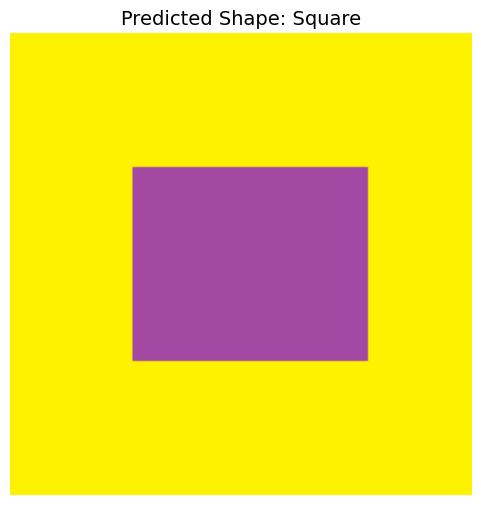

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

img_width = 200
img_height = 200

# Load the image
img_path = '/kaggle/input/tes-gambar/Tes/kotak.png'
img = Image.open(img_path).convert('RGB')
img = img.resize((img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Load the trained model
model_path = '/kaggle/input/shape_detector_model4/keras/default/1/shape_detector_model2.keras'
loaded_model = load_model(model_path)

# Make a prediction using the loaded model
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
predicted_shape = ['Circle', 'Square', 'Triangle','Lainnya'][predicted_class]

# Display the image and predicted shape
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Shape: {predicted_shape}', fontsize=14)
plt.show()
